# Data Preparation for Unet Training

In this file a dataset is created to train a 3D Unet with. This task encompasses the following steps:

- Open Tiff Stacks / h5 or n5 files
- data exploration and visualization
- sample mining
- creation of training datasets

In [1]:
import numpy as np 
import os, sys
import matplotlib.pyplot as plt
from importlib import reload

import h5py, z5py

import utilities

sys.path.append('../tools/')
import mosaic, datasetPreparation

## Open the file and load the potentially large image volume

In [2]:
# Open an image volume
image_path = "C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\large_image_0724.h5"
image_h5 = h5py.File(image_path, mode='r+') # Open h5 file with read / write access
print(image_h5['t0'].keys()) # Show Groups (Folders) in root Group of the h5 archive

image = image_h5['t0/channel0']

mask_path = "C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\large_mask_0724.h5"
mask_h5 = h5py.File(mask_path, mode='r') # Open h5 file with read / write access

mask = mask_h5['t0/channel0']
print('loaded image with shape {}\nloaded mask with shape {}'.format(image.shape, mask.shape))

<KeysViewHDF5 ['channel0', 'unet']>
loaded image with shape (500, 2000, 2000)
loaded mask with shape (500, 2000, 2000)


## Explore the data

The neuron is a branched and thin structure. While it's proportion is small in 3D images it occipies an even smaller proportion of the imaged volume.
While empty samples have to be included to train the network, samples containing the neuron should be preferred as they are much more informative.

### Thresholding by mean signal strength
As a proxy one could try to choose samples based on their mean signal strength.

In [3]:
reload(datasetPreparation)
reload(mosaic)

<module 'mosaic' from '../tools\\mosaic.py'>

In [4]:
# Use UnetTiler to tile the image volume with a rectangular grid
tiler = mosaic.UnetTiler3D(image=image, mask=mask, output_shape=(132,132,132), input_shape=(220,220,220))
# since input = ouput shape there is no padding

In [5]:
index, strength = datasetPreparation.sampleMeanSignalStrength(tiler, n_samples=300) # With about 17% of samples containing the neuron this should be enough sampling to collect 50 samples for the dataset

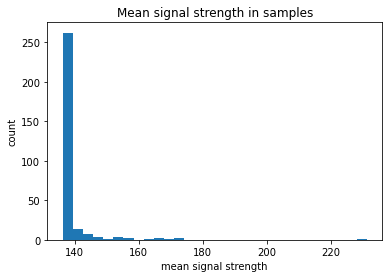

In [6]:
# Plot the distribution of the mean signal strength in our samples
_ = plt.hist(strength, bins=30)
plt.title('Mean signal strength in samples')
plt.xlabel('mean signal strength')
plt.ylabel('count')
plt.show()

In [7]:
np.count_nonzero([s > 139 for s in strength]) / len(index)

0.14666666666666667

In [8]:
# Prepare a dataset with thresholded Sampling:
thresholded = datasetPreparation.thresholdedSampling(index,strength,threshold=149,n_samples=50,object_ratio=0.9)

### Thresholding by proportion of masked volume (not background) in the sample mask
Alternatively, since a dataset is generated from labeled data, we can use the mean proportion of the masked volume to identify interesting samples

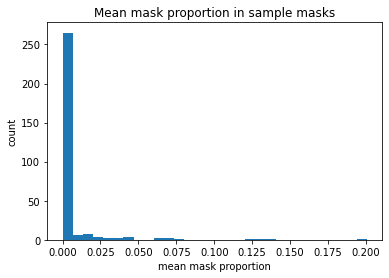

In [9]:
index, strength = datasetPreparation.sampleMaskProportion(tiler, n_samples=300)
# Plot the distribution of the mean signal strength in our samples
_ = plt.hist(strength, bins=30)
plt.title('Mean mask proportion in sample masks')
plt.xlabel('mean mask proportion')
plt.ylabel('count')
plt.show()

In [10]:
np.count_nonzero([s > 0.001 for s in strength])

50

In [11]:
# Prepare a detaset with mask thresholded sampling
mask_thresholded = datasetPreparation.thresholdedSampling(index, strength, threshold=0.001, object_ratio=0.9, n_samples=50)

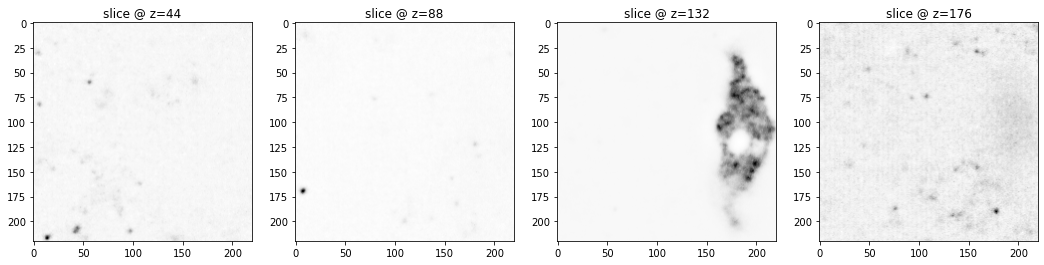

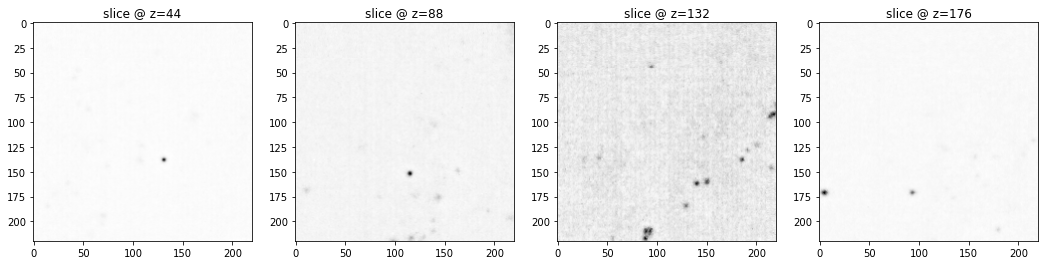

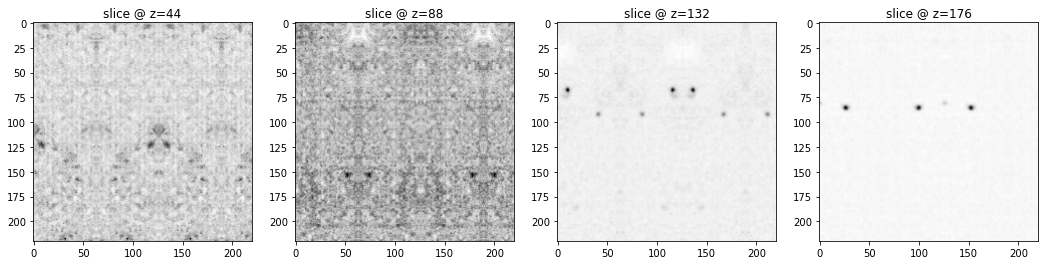

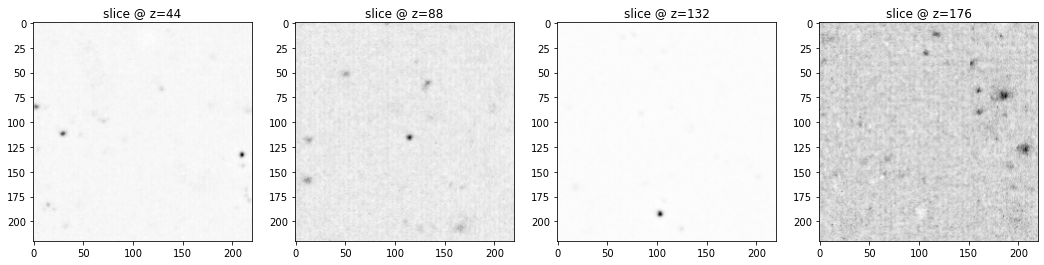

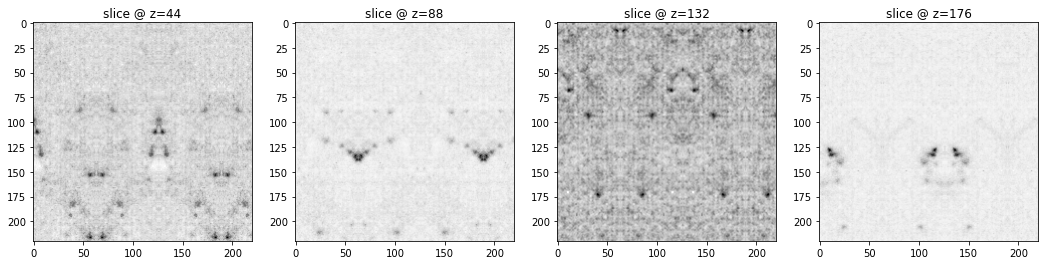

In [12]:
# Prepare a completely random sample from the dataset (baseline comparison):
random = np.random.choice(index, size=100)
for i in random[:5]:
    utilities.showZSlices(tiler._getSlice(i), mode='h5')

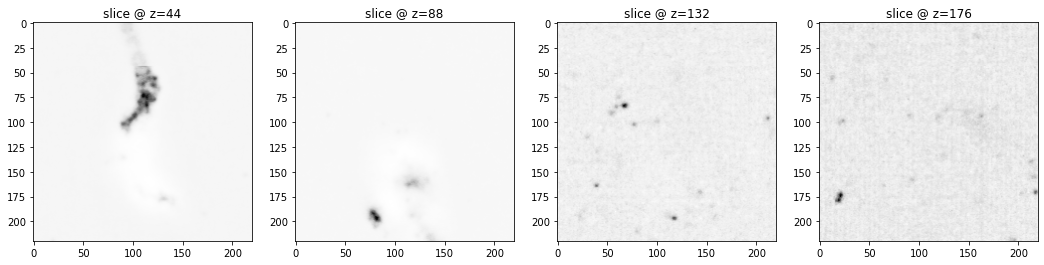

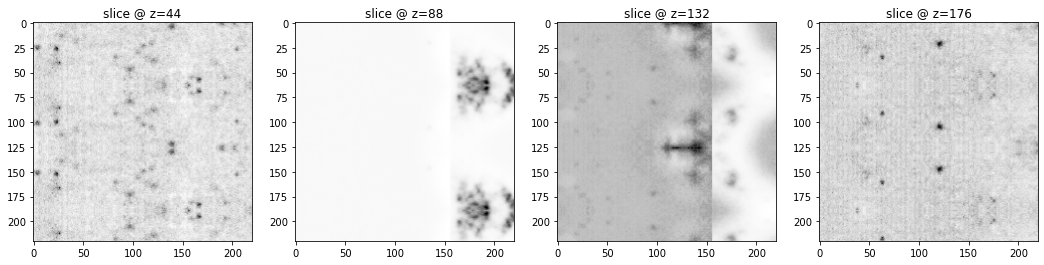

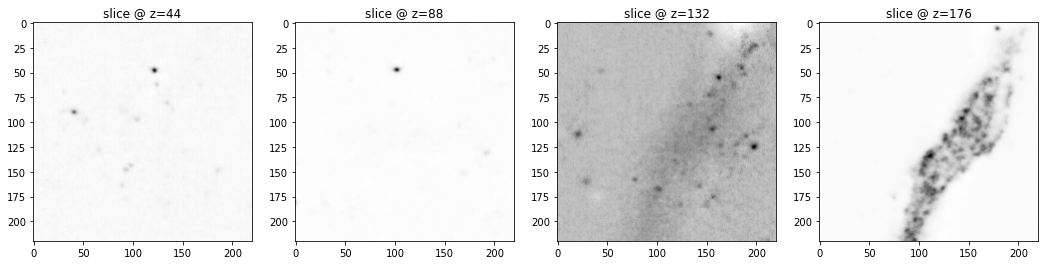

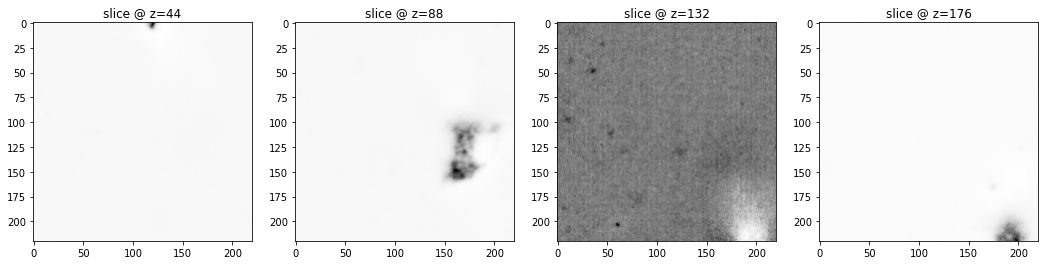

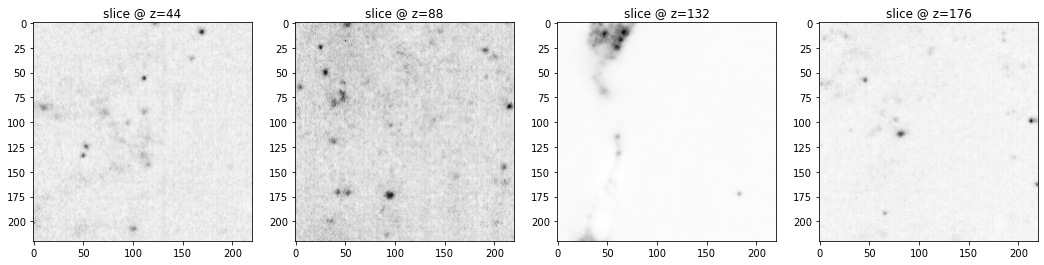

In [13]:
# Visualize the mean mean signal thresholded sampling
for i in thresholded[:5]:
    utilities.showZSlices(tiler._getSlice(i), mode='h5')

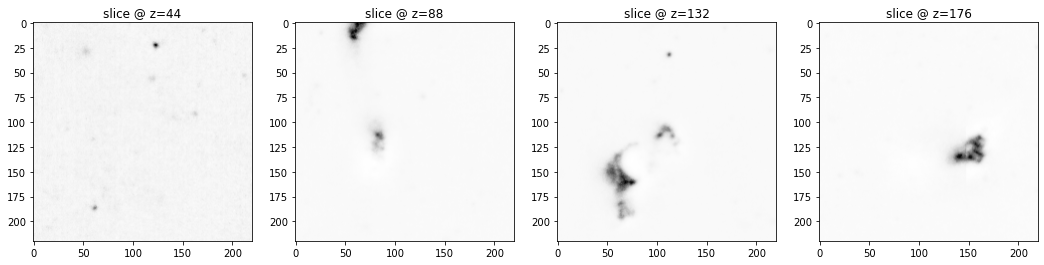

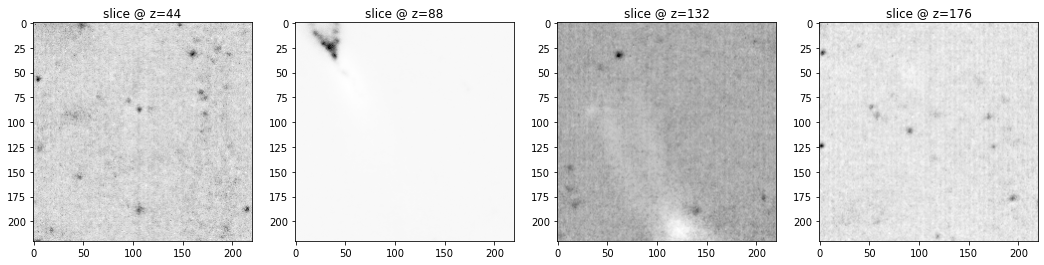

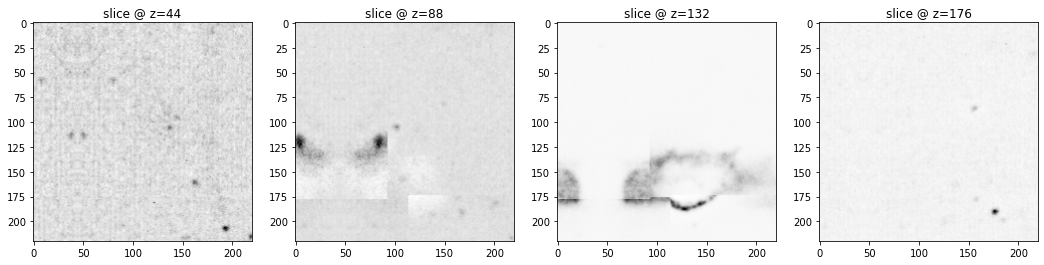

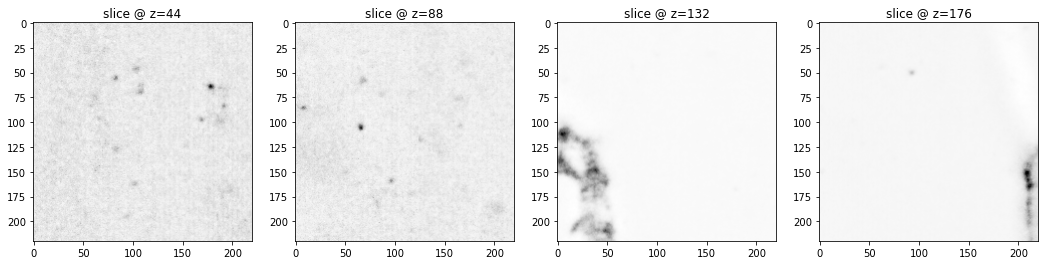

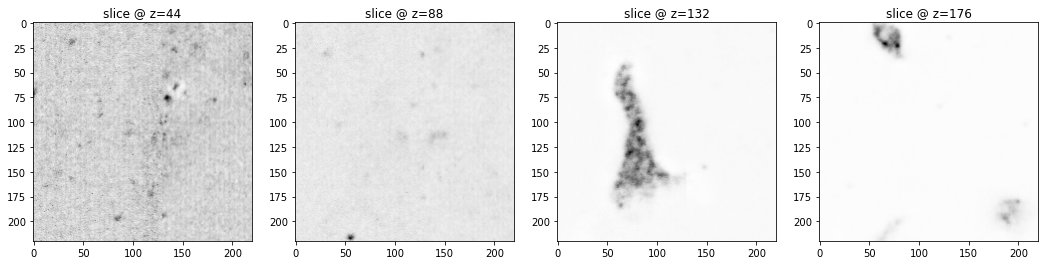

In [14]:
# Visualize the mask thresholded sampling
for i in mask_thresholded[:5]:
    utilities.showZSlices(tiler._getSlice(i), mode='h5')

In [15]:
# Visualize which regions were sampled from the tiling, verify overlap with dataset content
thresholded_dist = np.zeros((4,16,16))
for sample in thresholded:
    coords = tiler._indexToCoordinates(sample)
    thresholded_dist[coords] = 1

mask_thresholded_dist = np.zeros((4,16,16))
for sample in mask_thresholded:
    coords = tiler._indexToCoordinates(sample)
    mask_thresholded_dist[coords] = 1 

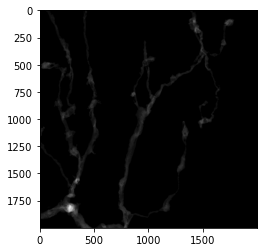

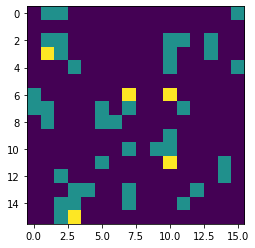

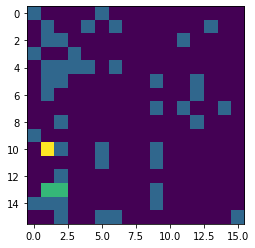

In [16]:
plt.figure('Z Projection of image volume')
plt.imshow(np.sum(np.clip(mask,0,1), axis=0), cmap='gray')
plt.figure('Z Projection of samples taken by thresholding')
plt.imshow(np.sum(thresholded_dist, axis=0))
plt.figure('Z Projection of samples taken by mask thresholding')
plt.imshow(np.sum(mask_thresholded_dist, axis=0))

In [17]:
# Create a training dataset stored as hdf5 file
# Store images and masks in two separate groups
dataset_h5 = h5py.File('C:\\Users\\Linus Meienberg\\Documents\\ML Datasets\\FruSingleNeuron_20190707\\dataset_0727')
image_dir = dataset_h5.create_group('image')
mask_dir = dataset_h5.create_group('mask')
print(dataset_h5.keys())


<KeysViewHDF5 ['image', 'mask']>


In [18]:
def preprocessImage(data):
    # clip the values at 1400 so that everything above is saturated
    data = np.clip(data, 0, 1400)
    # shift by the empirical mean and divide by the empirical std dev to get data with a approx 0 centered distribution and unit variance
    # this improves weight stability in the lower layers and allows for faster training
    # empirical values for mean and variance were obtained using image J on large_image_0724.h5
    data = np.divide( np.subtract(data, 140), 40 )
    return data

def preprocessMask(data):
    return np.clip(data,0,1) # binarize masks

In [19]:
for index in mask_thresholded:
    # create a dataset holding the input image region
    data = tiler._getSlice(index)
    data = preprocessImage(data)
    image_dir.create_dataset(str(index), data=data)
    # create a detaset holding the output region of the mask
    data = tiler._getMaskSlice(index)
    data = preprocessMask(data)
    mask_dir.create_dataset(str(index), data=data) 

In [20]:
# Close the dataset
print(image_dir.keys())
dataset_h5.close()

<KeysViewHDF5 ['123', '209', '226', '242', '255', '256', '261', '273', '289', '290', '299', '307', '322', '326', '338', '345', '364', '377', '382', '417', '425', '437', '441', '465', '466', '473', '489', '501', '502', '532', '541', '560', '577', '579', '580', '593', '604', '652', '656', '673', '677', '722', '736', '790', '898', '929', '930', '962', '97', '993']>
